In [245]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from math import sqrt

In [246]:
# Data loading and analysis
csv_path = 'datasets_56102_107707_monthly-beer-production-in-austr.csv'
df = pd.read_csv(csv_path, parse_dates=['Month'], index_col='Month')

idx = df.index
is_datetime = isinstance(idx, pd.DatetimeIndex)
is_monotonic = idx.is_monotonic_increasing
has_duplicates = idx.duplicated().any()
inferred_freq = pd.infer_freq(idx)

print("Index is DatetimeIndex:", is_datetime)
print("Index is monotonic increasing:", is_monotonic)
print("Index has duplicate timestamps:", has_duplicates)
print("pandas.infer_freq:", inferred_freq)

if is_datetime:
    # expected monthly index (month-start) between min and max
    expected = pd.date_range(start=idx.min(), end=idx.max(), freq='MS')
    missing_months = expected.difference(idx)
    print("\nNumber of expected months between min and max:", len(expected))
    print("Number of actual rows:", len(idx))
    print("Number of missing months:", len(missing_months))
    if len(missing_months) > 0:
        print("Missing months detected.")
    else:
        print("No missing months detected between min and max (based on MS frequency).")

    frequency_ok = (len(missing_months) == 0) and (inferred_freq is not None)
    print("\nContinuous measurements with consistent frequency", frequency_ok)

print("Synchrony across multiple variables: not applicable (only one measured variable, no missing data points).")


Index is DatetimeIndex: True
Index is monotonic increasing: True
Index has duplicate timestamps: False
pandas.infer_freq: MS

Number of expected months between min and max: 476
Number of actual rows: 476
Number of missing months: 0
No missing months detected between min and max (based on MS frequency).

Continuous measurements with consistent frequency True
Synchrony across multiple variables: not applicable (only one measured variable, no missing data points).


In [ ]:
# Checking for outliers using the STL residues with Mean Absolute Deviation (MAD)
colname = df.columns[0]
series = df[colname]
series_ms = series.copy().asfreq('MS')

stl = STL(series_ms, period=12, robust=True).fit()
resid = stl.resid.dropna()

mad = (resid - resid.median()).abs().median()
threshold = 3 * mad
outliers = resid[resid.abs() > threshold]

print(f'\nMAD = {mad:.3f}, outlier threshold = 3*MAD = {threshold:.3f}')
print('Number of flagged outliers:', len(outliers))


MAD = 2.960, outlier threshold = 3*MAD = 8.881
Number of flagged outliers: 59


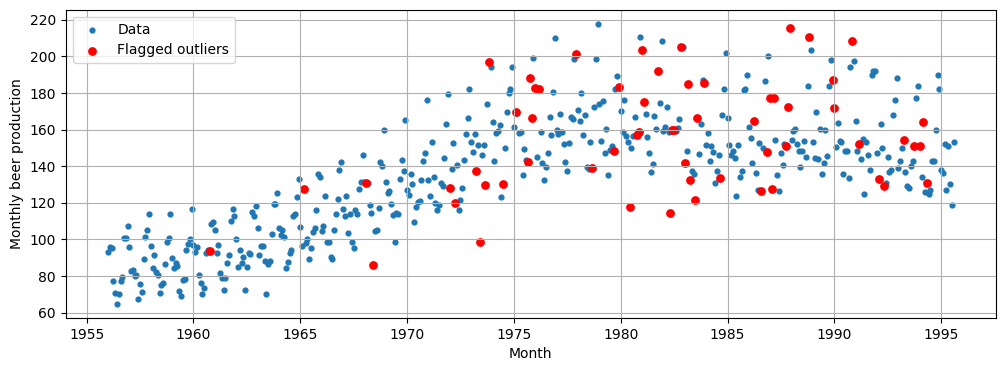

In [248]:
plt.figure(figsize=(12, 4))
plt.scatter(series_ms.index, series_ms.values, s=12, c='tab:blue', label='Data')

if len(outliers) > 0:
    out_idx = outliers.index
    out_vals = series_ms.loc[out_idx]
    plt.scatter(out_idx, out_vals.values, s=28, c='red', label='Flagged outliers')

plt.xlabel('Month')
plt.ylabel(colname)
plt.legend()
plt.grid(True)
plt.show()


In [249]:
# Baseline model
series_vals = df[colname].values.astype(float)
dates = df.index.to_numpy()
T = 12

X_list, Y_list, Y_dates = [], [], []
for t in range(T, len(series_vals)):
    X_list.append(series_vals[t-T:t])
    Y_list.append(series_vals[t])
    Y_dates.append(dates[t])

X_all = np.array(X_list).reshape(-1, T)
Y_all = np.array(Y_list)
Y_dates = np.array(Y_dates)

print('Built sliding windows:', 'X_all.shape =', X_all.shape, 'Y_all.shape =', Y_all.shape)

train_end = np.datetime64('1983-09-01')

train_last_idx = np.where(Y_dates <= train_end)[0]
train_last_idx = train_last_idx[-1]
# Slices
X_train, Y_train = X_all[:train_last_idx+1], Y_all[:train_last_idx+1]
X_val, Y_val = X_all[train_last_idx+1:], Y_all[train_last_idx+1:]

print(f'Train samples: {len(X_train)}, Validation samples: {len(X_val)}')

Built sliding windows: X_all.shape = (464, 12) Y_all.shape = (464,)
Train samples: 321, Validation samples: 143


Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1284.7219 - val_loss: 683.2363
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 559.5126 - val_loss: 595.8276
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 418.1187 - val_loss: 788.5413
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 456.4572 - val_loss: 591.6114
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 347.5852 - val_loss: 463.3319
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 320.2935 - val_loss: 439.6411
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 287.0135 - val_loss: 386.7501
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 270.3080 - val_loss: 343.2171
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 241.8510 - val_loss: 321.4017
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 228.9971 - val_loss: 288.1789
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 210.3833 - val_loss: 266.7388
Epoch 12/40
11/11 ━━━━━━━━━━

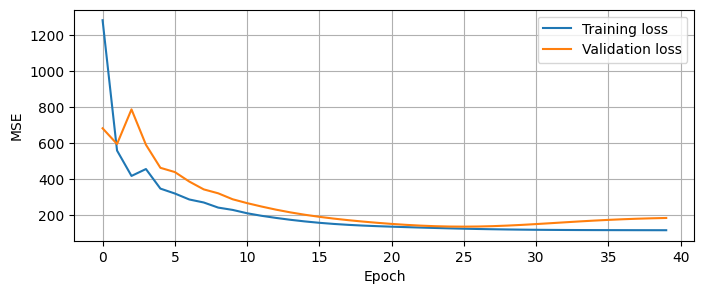

In [250]:
# Build and train autoregressive dense model
i = Input(shape=(T,))
x = Dense(1)(i)
lr = 0.05
epochs = 40

model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=lr))

r = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), shuffle=False)

plt.figure(figsize=(8,3))
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

Validation MAE: 69.306 -  Validation RMSE: 82.349


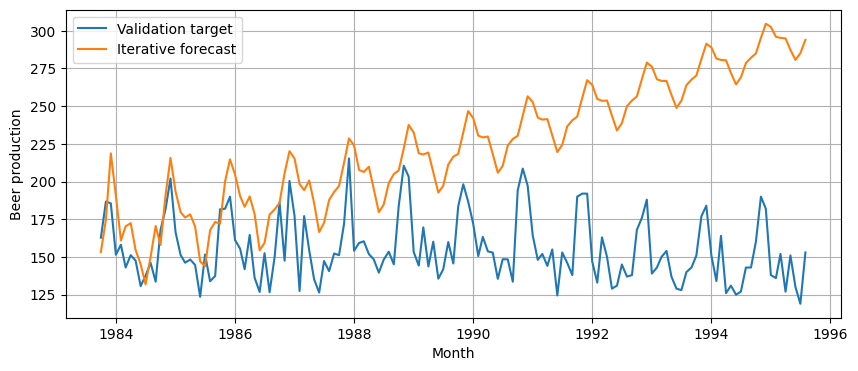

In [ ]:
# Validation
h = len(Y_val)
validation_target = Y_val.copy()
validation_predictions = []

# Start from the last input window from training
last_x = X_train[-1].copy()

for _ in range(h):
    p = model.predict(last_x.reshape(1, -1), verbose=0)[0, 0]
    validation_predictions.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

validation_predictions = np.array(validation_predictions)

mae = np.mean(np.abs(validation_predictions - validation_target))
rmse = sqrt(np.mean((validation_predictions - validation_target)**2))

print(f'Validation MAE: {mae:.3f} -  Validation RMSE: {rmse:.3f}')

plt.figure(figsize=(10, 4))
plt.plot(Y_dates[train_last_idx+1:], validation_target, label='Validation target')
plt.plot(Y_dates[train_last_idx+1:], validation_predictions, label='Iterative forecast')
plt.xlabel('Month')
plt.ylabel('Beer production')
plt.legend()
plt.grid(True)
plt.show()


Quite a lot of variance in results for the iterative forecast. Sometimes the baseline model performs very poorly on the validation data. It tends to over or under estimate the validation target toward the end of the data.